<p  style="text-align: left;font-family: consolas; font-size: 12px; font-weight:bold;">
    author: Tsiapras Tilemachos 
</p>
<p  style="text-align: left;font-family: consolas; font-size: 12px; font-weight:bold;">
    date: 23/03/2022
</p>
<p  style="text-align: left;font-family: consolas; font-size: 12px; font-weight:bold;">
    revision: 1
</p>

<h1 style="text-align: center;font-family: verdana;">
    Step by Step
</h1>
<p  style="text-align: center;font-family: verdana; font-size: 18px;">
    Process for disparity extraction from stereo pair of images
</p>


### Pages used to enlighten me

https://www.andreasjakl.com/

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_table_of_contents_calib3d/py_table_of_contents_calib3d.html

https://medium.com/@dc.aihub/3d-reconstruction-with-stereo-images-part-1-camera-calibration-d86f750a1ade

https://medium.com/@dc.aihub/3d-reconstruction-with-stereo-images-part-2-pose-estimation-1bcfbba61b26

https://medium.com/@dc.aihub/3d-reconstruction-with-stereo-images-part-3-epipolar-geometry-98b75e40f59d

https://medium.com/@dc.aihub/3d-reconstruction-with-stereo-images-part-4-depth-map-19ff205b060e

https://learnopencv.com/getting-started-opencv-cuda-module/

https://github.com/aliyasineser/stereoDepth/blob/master/getStereoImages.py

<h1 style="text-align: center;font-family: consolas;">
    Step [1]
</h1>
<h2 style="text-align: center;font-family: consolas;">
    Correction of barrel distortion & extraction of intrinsic parameters
</h2>

<p  style="text-align: left;font-family: consolas; font-size: 14px;">
First step in any processing with an image is the assumption that the pinhole camera model is used. This model allows us to compute the position of a point in the 2d image plane knowing the 3d position of that point.
</p>

![pinholeModel](https://github.com/TsiaprasTilemachos/prism_sucker/blob/main/images/PinholeModel.png?raw=true)

<p  style="text-align: left;font-family: consolas; font-size: 14px;">
One of the main properties of the pnihole model is that it retains straitness, meaning that strait lines in the 3d world remain strait in the 2d Projection onto the image plane. unfortunately real work is never perfect and the pinhole cameras are not practical for real use. In real application lenses are used to focus multiple rays of light caming from a 3d Point ito a single 2d Point (or an areas smaller than a pixel). These lenses, especially cheap ones, introduce distortion in an image.</p>

[More on distorion](https://www.image-engineering.de/library/image-quality/factors/1062-distortion)

<p  style="text-align: left;font-family: consolas; font-size: 14px;">
The effect, in this case, of barrel distortion is clearly visible in the image below, taken from the web camera that i am going to use for these tests.</p>

<img src="https://github.com/TsiaprasTilemachos/prism_sucker/blob/main/images/checkerboardWithDistortion.jpg?raw=true" alt="checkerboard with distortion" width="500"/>

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from tabulate import tabulate

In [2]:
def takePicture(dev = 0):
    #Press q to keep last frame
    cap = cv.VideoCapture(dev)
    counter = 0
    key=-1
    while(counter<10000):
        ret, frame = cap.read()
        cv.imshow("webCam",frame)
        key = cv.waitKey(5)
        if key==113 or key==13:
            break    
        counter+=1

    cv.destroyAllWindows()
    cap.release()
    return(frame)

def show(img):
    cv.imshow('temp',img)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
def drawPoints(img, pts, colors):
    for pt, color in zip(pts, colors):
        cv.circle(img, tuple(pt[0]), 3, color, -1)

<p  style="text-align: left;font-family: consolas; font-size: 14px;">
The target of the calibration target is to find the internal parameters of the camera including the parameters of any distortion affecting the imaging device. For our tests I am using a checkerboard target with 7X4 internat corners. We use the checkerboard as it provides a good feature to detect with accuracy. 
</p>

<img src="https://github.com/TsiaprasTilemachos/prism_sucker/blob/main/images/target7x4.png?raw=true" alt="target7x4" width="400"/>


<p  style="text-align: left;font-family: consolas; font-size: 14px;">
The target must me mounted in a flat surface so we can make an all important assumption. We assume that the world coordinates have as origin the upper left corner of out target and each corner is 1 unit away from the next. 
</p>

<img src="https://github.com/TsiaprasTilemachos/prism_sucker/blob/main/images/planeZ0.jpg?raw=true" alt="target7x4" width="400"/>

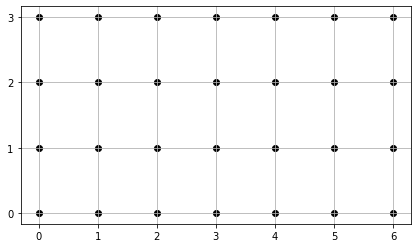

In [3]:
# Object points in the 3d World

objp = np.zeros((7*4,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:4].T.reshape(-1,2)

plt.figure(figsize=(7,4))
plt.scatter(objp[:,0],objp[:,1],c='k')
plt.yticks([0,1,2,3])
plt.grid()

<p  style="text-align: left;font-family: consolas; font-size: 14px;">
Now I am capturing multiple images of the same target form different angles. The internal corners of the target must be clearly vissible in all of the captured frames.
</p>

In [15]:
cap = cv.VideoCapture(1)# 1 because I use an external usb Webcamera

imgs=[]
key=-1

# Capture 10 frames by pressing ENTER. <q> will stop this process
for i in tqdm(range(12)):
    while(1):
        ret, frame = cap.read()
        cv.imshow("webCam",frame)
        key = cv.waitKey(50)
        if key==13:
            imgs.append(frame[:,:,:])
            break
            
cv.destroyAllWindows()
cap.release()

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:02<00:00,  6.54s/it]


In [462]:
# Load precaptured images
# imgs = []
# for i in range(12):
#     imgs.append(cv.imread(r"images\uncalib{:d}.jpg".format(i),1))

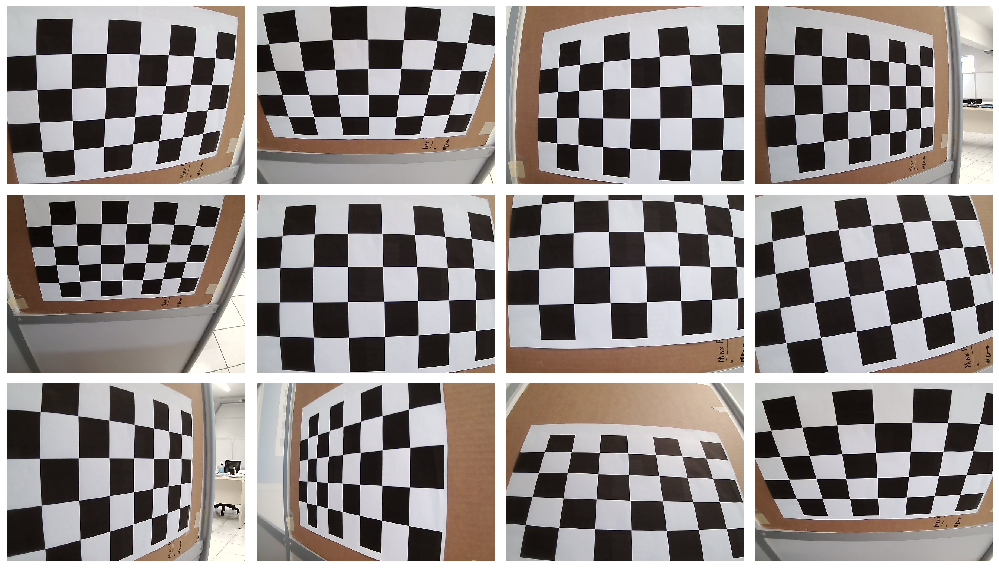

In [5]:
fig = plt.figure(figsize=(14,8))

for i,img in enumerate(imgs):
    fig.add_subplot(3,4,i+1)
    plt.imshow(img[:,:,[2,1,0]])
    plt.axis('off')
    
plt.tight_layout()

<p  style="text-align: left;font-family: consolas; font-size: 18px;">
I now detect the target corners in all calibration frames. The code will pass through all of them showing only the images which included detectable corners. When passing through the images press <Enter> in all images that the corners where correctly detected. If not press any other key to go to the next
</p>

In [6]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for img in imgs:
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    imgN = np.copy(img)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,4),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Draw and display the corners
        cv.drawChessboardCorners(imgN, (7,4), corners,ret)
        cv.imshow('img',imgN)
        key = cv.waitKey(0)
        if key==13:
            imgpoints.append(corners)
            objpoints.append(objp)
        

    cv.destroyAllWindows()

### Now we can proceed with the calibration

In [7]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [8]:
print(" Intrinsic matrix")
print(tabulate(mtx, tablefmt="github"))
print("\n Distortion Parameters")
print(tabulate(dist, tablefmt="github"))


 Intrinsic matrix
|---------|---------|---------|
| 617.107 |   0     | 287.878 |
|   0     | 614.203 | 259.979 |
|   0     |   0     |   1     |

 Distortion Parameters
|-----------|----------|-------------|------------|------------|
| -0.363826 | 0.155789 | -0.00131436 | 0.00110382 | -0.0487088 |


<h2 style="text-align: center;font-family: consolas;">
    Undistorting
</h2>
<p  style="text-align: left;font-family: consolas; font-size: 18px;">
Using the Intrinsic parameters and teh distortino parameters i can now reverse the effectes of the lenses.
</p>

In [9]:
# take a new picture
unCal = takePicture(dev = 1)

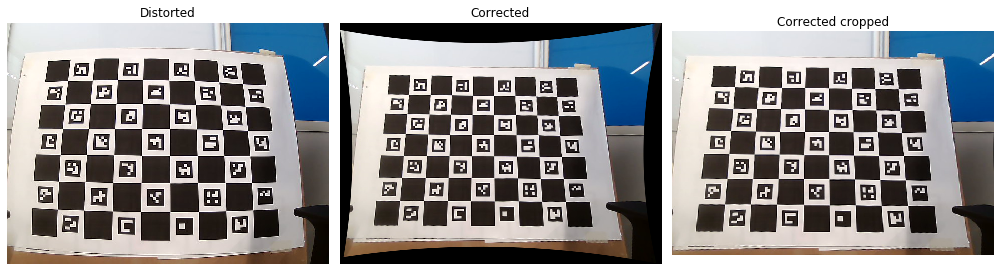

In [11]:
#refine the camera matrix that hold our intrinsic values 
h,  w = unCal.shape[:2]
newcameramtx, roi=cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
Cal = cv.undistort(unCal, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
Cal_cropped = Cal[y:y+h, x:x+w]



fig = plt.figure(figsize=(14,8))

fig.add_subplot(1,3,1)
plt.imshow(unCal[:,:,[2,1,0]])
plt.title("Distorted")
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(Cal[:,:,[2,1,0]])
plt.title("Corrected")
plt.axis('off')

fig.add_subplot(1,3,3)
plt.imshow(Cal_cropped[:,:,[2,1,0]])
plt.title("Corrected cropped")
plt.axis('off')
    
plt.tight_layout()

<p  style="text-align: left;font-family: consolas; font-size: 18px;">
We can now apply the correction to a live video feed from out webCam
</p>

In [58]:
cap = cv.VideoCapture(1)
counter = 0
key=-1
# Press <q> to stop
while(counter<10000):
    ret, frame = cap.read()
    frame = frame[:,:,:]
    
    dst = cv.undistort(frame, mtx, dist, None, newcameramtx)
    dst = dst[y:y+h, x:x+w]

    cv.imshow("webCam",dst)
    key = cv.waitKey(5)
    if key==113:
        break    
    counter+=1

cv.destroyAllWindows()
cap.release()

<h2 style="text-align: center;font-family: consolas;">
    Part 2 Pose Estimation
</h2>

In [76]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

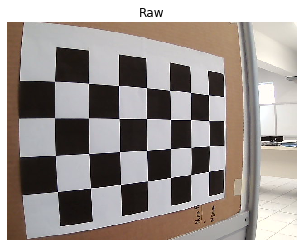

In [83]:
image = imgs[3]
_=plt.imshow(image[:,:,[2,1,0]])
_=plt.title("Raw")
_=plt.axis('off')

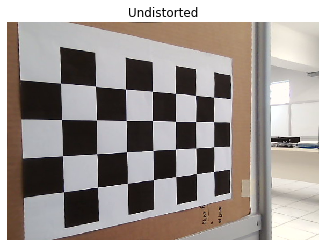

In [84]:
undist = cv.undistort(image, mtx, dist, None, newcameramtx)
undist = undist[y:y+h, x:x+w]

_=plt.imshow(undist[:,:,[2,1,0]])
_=plt.title("Undistorted")
_=plt.axis('off')

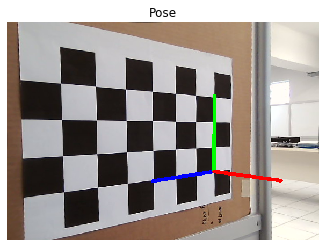

In [85]:
#find corners
gray = cv.cvtColor(undist,cv.COLOR_BGR2GRAY)
ret, corners = cv.findChessboardCorners(gray, (7,4),None)

if ret == True:
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    # 3D POINTS, PROJECTIONS ON IMAGE PLANE, INTRINSIC PARAMETERS, DISTORD COEFFICIENTS 
    _, rvecs, tvecs, inliers = cv.solvePnPRansac(objp, corners2, mtx, dist)
    
    # project 3D points to image plane
    axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
    imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)
    draw(undist,corners2.astype(int),imgpts.astype(int))
    
    _=plt.imshow(undist[:,:,[2,1,0]])
    _=plt.title("Pose")
    _=plt.axis('off')

<h2 style="text-align: center;font-family: consolas;">
    Part 3 Image Rectification
</h2>

In [426]:
# Take a new pair of photos
left  = takePicture(dev=1)
right = takePicture(dev=1)

# Or lod a already stored pair
# left = cv.imread(r"C:\Users\ttsiapras\Documents\AUX_INFO\IMAGE_PROCESS\STEREO\images\russia_L.jpg",0)
# right = cv.imread(r"C:\Users\ttsiapras\Documents\AUX_INFO\IMAGE_PROCESS\STEREO\images\russia_R.jpg",0)
# img1 = left
# img2 = left


In [481]:
# crop the image
h,  w = left.shape[:2]
newcameramtx, roi=cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
x,y,w,h = roi

# undistort
dst = cv.undistort(left, mtx, dist, None, newcameramtx)
img1 = dst[y:y+h, x:x+w]

dst = cv.undistort(right, mtx, dist, None, newcameramtx)
img2 = dst[y:y+h, x:x+w]

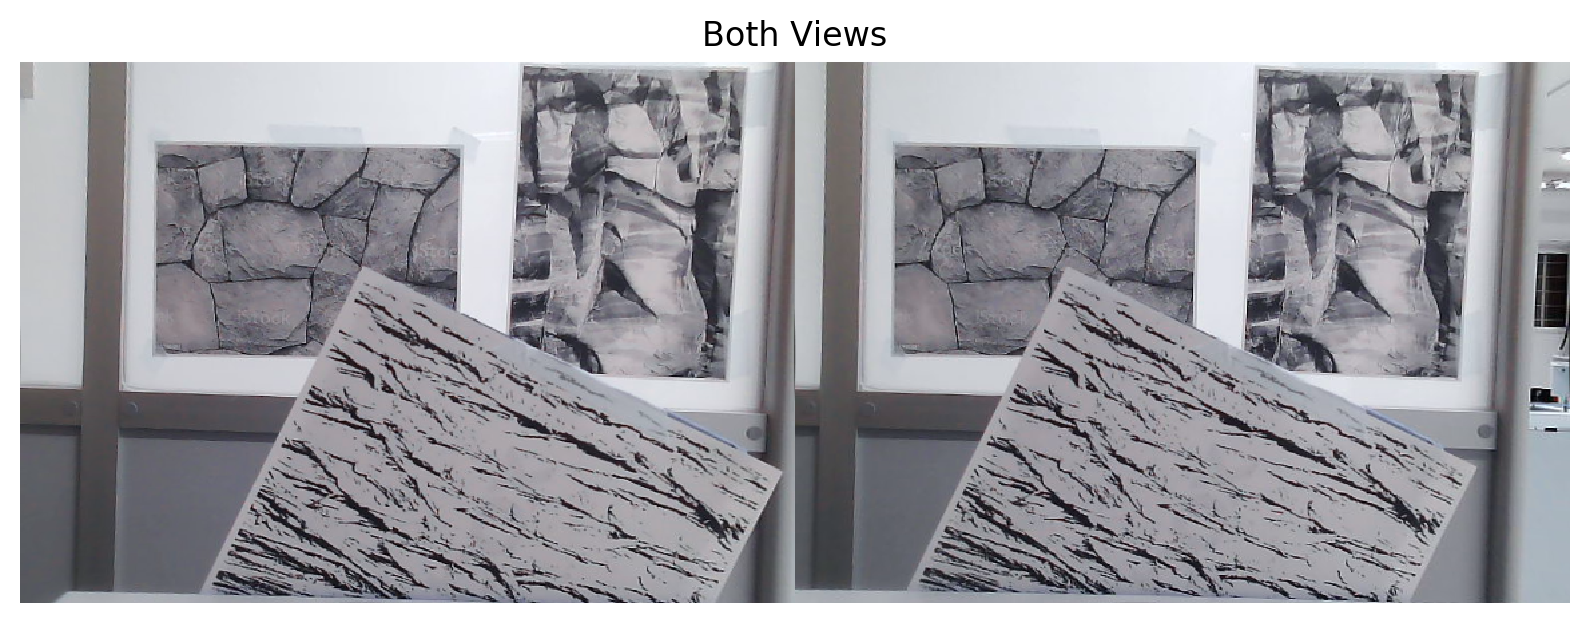

In [482]:
both = np.concatenate([img1,img2],axis=1)
mpl.rcParams['figure.dpi'] = 200

_=plt.figure(figsize=(10,5))
_=plt.imshow(both[:,:])
_=plt.title("Both Views")
_=plt.axis('off')

(-0.5, 579.5, 404.5, -0.5)

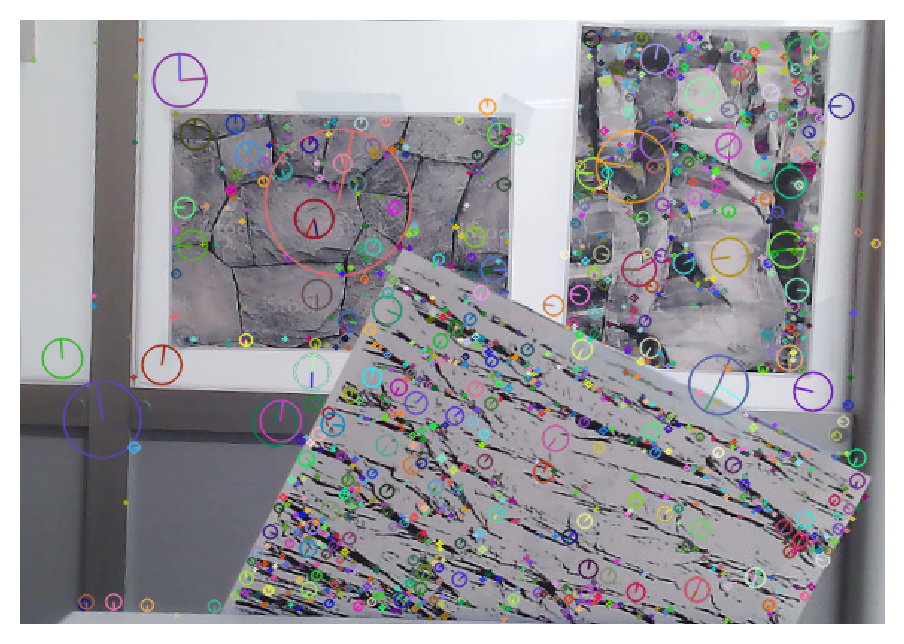

In [484]:
# 1. Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

#draw the keypoints in one of the images
imgSift = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
mpl.rcParams['figure.dpi'] = 200
plt.imshow(imgSift)
plt.axis("off")

In [545]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 2
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.2*n.distance:   # the multiplication is the only tunable parameter
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [546]:
# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html


draw_params = dict(matchColor=(0, 255, 0),
               singlePointColor=(255, 0, 0),
               matchesMask=matchesMask[:],
               flags=cv.DrawMatchesFlags_DEFAULT)
keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[:], None, **draw_params)
cv.imshow("Keypoint matches", keypoint_matches)
cv.waitKey(0)
cv.destroyAllWindows()

In [547]:
# STEREO RECTIFICATION

# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

In [548]:
print(fundamental_matrix)

[[ 6.73145908e-07 -5.68207774e-04  1.23861605e-01]
 [ 5.20671951e-04 -6.42777113e-05 -1.11732957e+00]
 [-1.14502014e-01  1.12364353e+00  1.00000000e+00]]


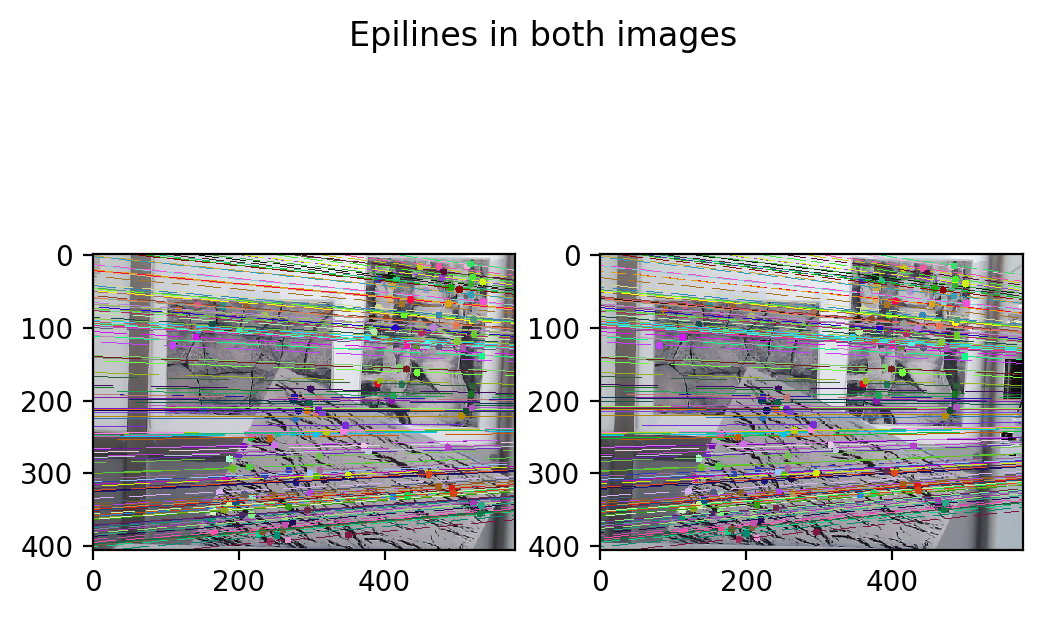

In [549]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c,_ = img1src.shape
    #uncomment for greyscale images
    #img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    #img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1src, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1src, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2src, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1.copy(), img2.copy(), lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2.copy(), img1.copy(), lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

In [550]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1, _= img1.shape
h2, w2, _ = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

In [551]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)

True

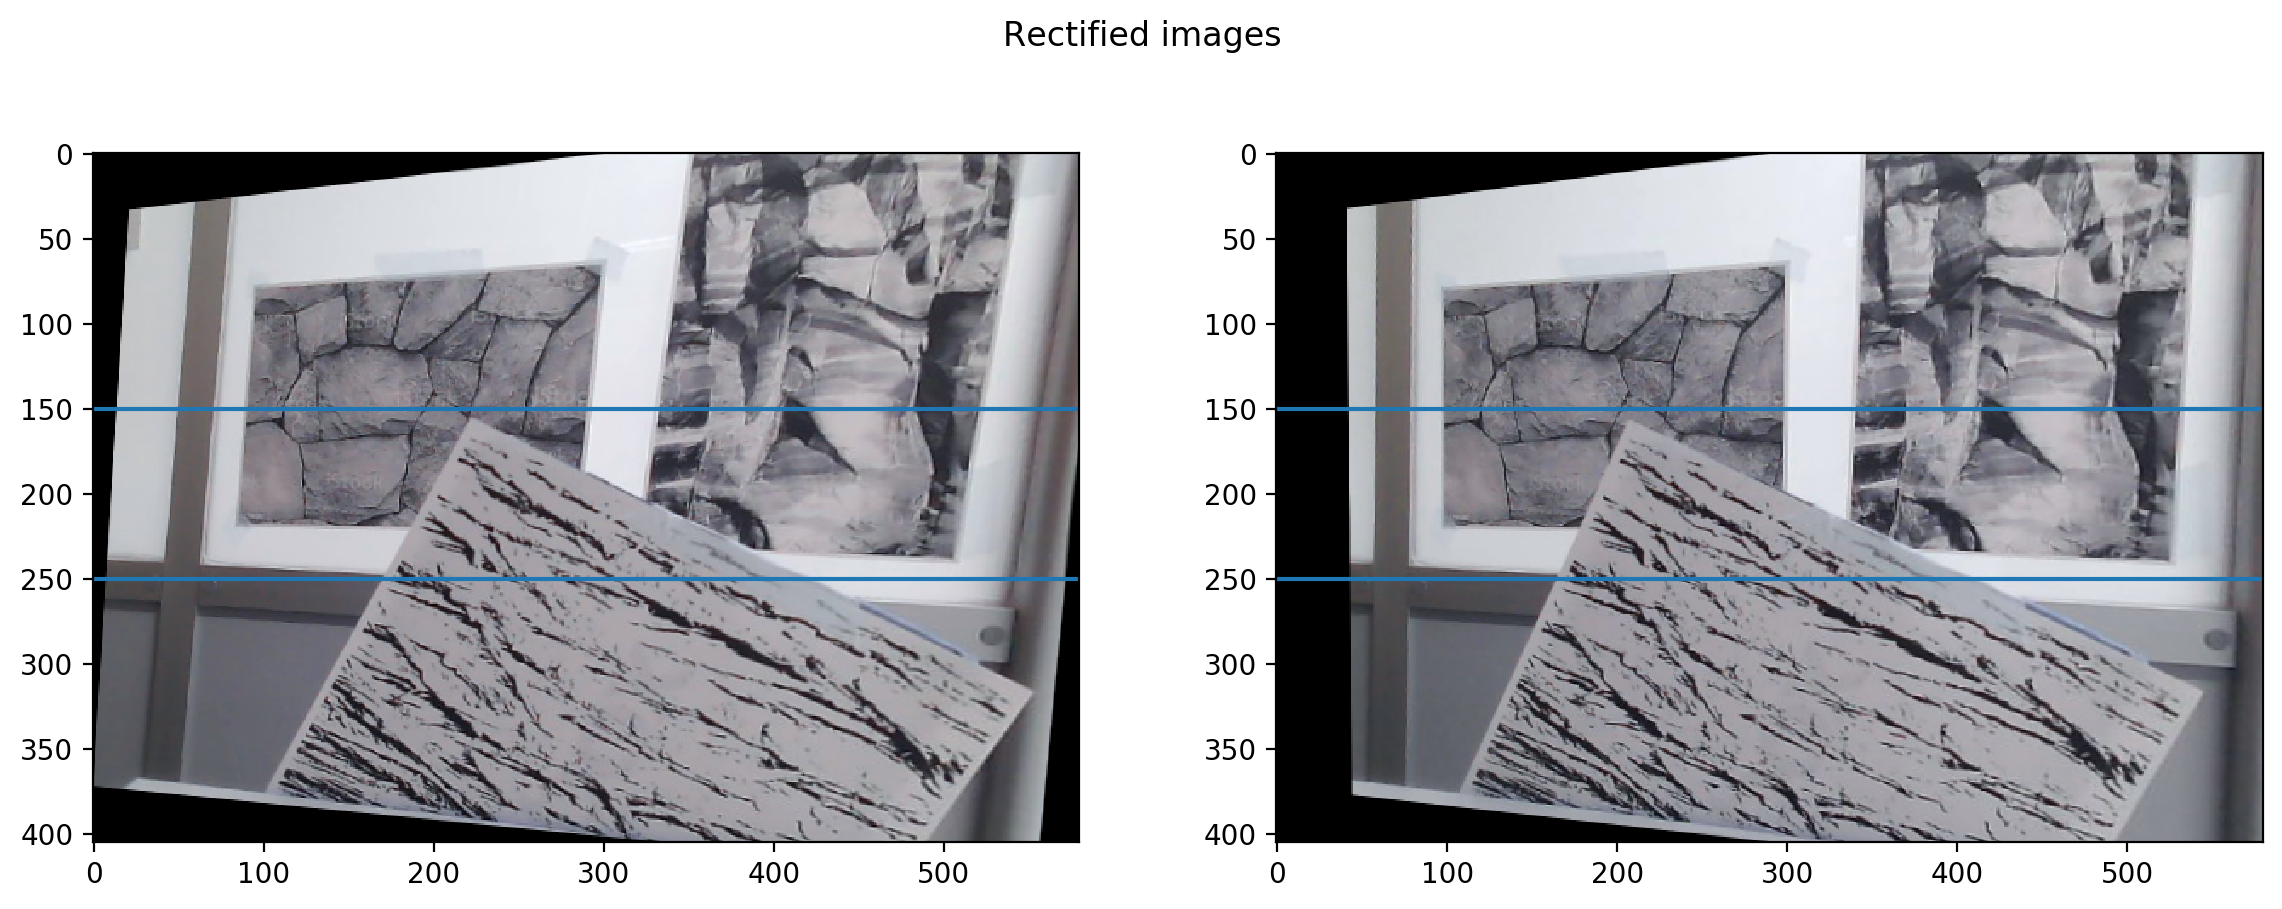

In [552]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(150)
axes[1].axhline(150)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

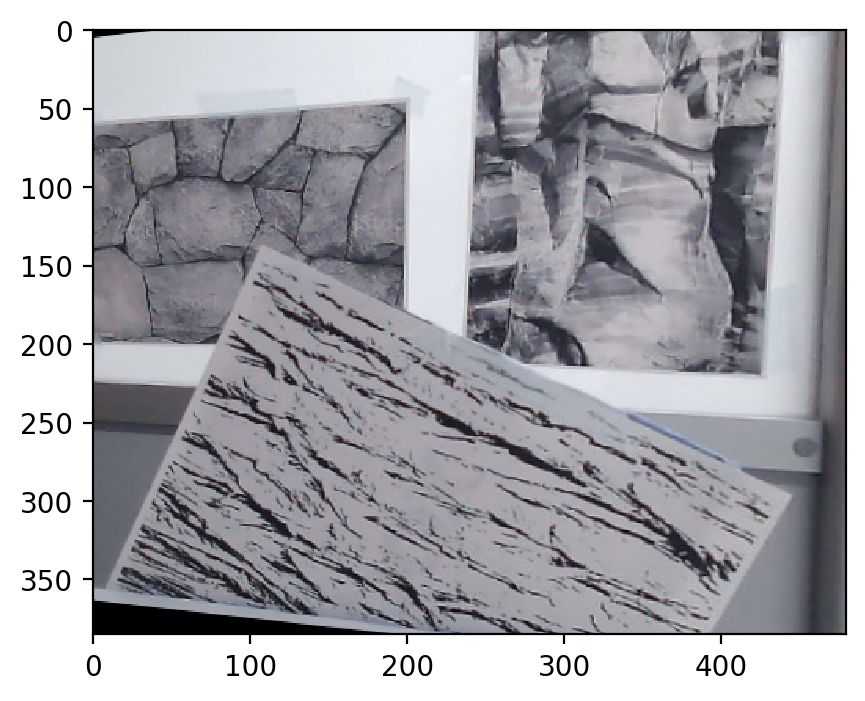

In [553]:
l = img1_rectified[20:,100:,:]
r = img2_rectified[20:,100:,:]
plt.imshow(r)

<h1 style="text-align: center;font-family: consolas;">
    StereoBM
</h1>

(-0.5, 579.5, 404.5, -0.5)

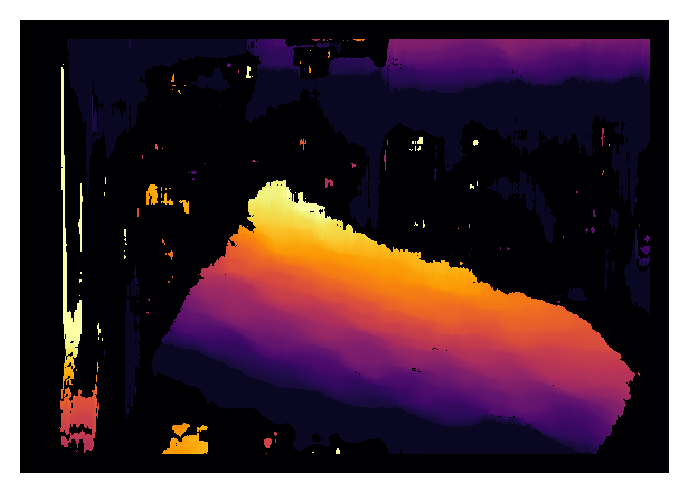

In [560]:
#Disparity
stereo = cv.StereoBM_create(numDisparities=16, blockSize=35)
stereo.setUniquenessRatio(9)
disparity = stereo.compute(cv.cvtColor(img1_rectified, cv.COLOR_BGR2GRAY),cv.cvtColor(img2_rectified, cv.COLOR_BGR2GRAY))

disparity = cv.normalize(disparity, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity = np.uint8(disparity)
    
plt.figure(figsize=(5,3))
plt.imshow(disparity,cmap="inferno")
plt.axis("off")

<h1 style="text-align: center;font-family: consolas;">
    StereoSGBM
</h1>

(-0.5, 579.5, 404.5, -0.5)

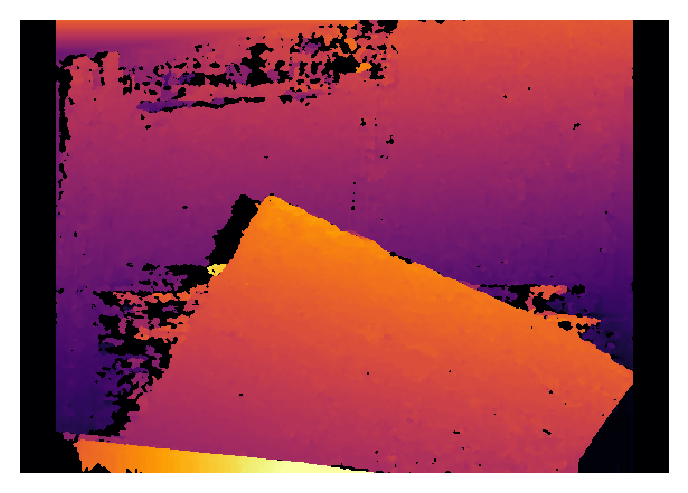

In [567]:
# ------------------------------------------------------------
# CALCULATE DISPARITY (DEPTH MAP)
# Adapted from: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
# and: https://docs.opencv.org/master/dd/d53/tutorial_py_depthmap.html

# StereoSGBM Parameter explanations:
# https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size = 3
#min_disp = -max_disp
min_disp = -32
max_disp = 32
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 50
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity_SGBM = stereo.compute(img1_rectified,img2_rectified)

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)


plt.figure(figsize=(5,3))
plt.imshow(disparity_SGBM,cmap="inferno")
plt.axis("off")
#cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)

In [362]:
cv.destroyAllWindows()